# Machinaal Leren - Sprint 3: Multiple data sources

## Task:
Use the images or external data sources (eg. Ghent open data)

Possible tasks:
* Use the images to find similar listings (e.g. similar interior style)
* Cluster the images
* Automatically detect attributes of the listing (e.g. garden, bath, shower, washing machine, ...) based on the images
* Find duplicate listings based on the images
* Detect anomalies (rooms that look very different)
* Predict which room a picture is taken in (bedroom, bathroom, outside, ...)
* Combine with external data to better predict the price (e.g. location of public transport, proximity to attractions, ...)
* ...

## Work table

|Task|Peter Bonnarens|Philip Kukoba|Lennert Franssens|
|------|------|------|------|
|1. Loading and cleaning dataset  | X |  |  |
|2. Find similar listings  | X |  |   |
|3. Find duplicate listings  |   |  |   |
|4. Cluster the images  |   |   |  |
|5. Detect attributes of the listing  |   |   |  |
|6. Detect anomalies  |   |   |  |
|7. Predict which room a picture is taken in  |   |   |  |
|8. Use external data to better predict the price  |   |   |  |
|9. Extra 1  |   |   |  |
|10. Extra 2  |   |   |  |
|11. Extra 3  |   |   |  |

# **1 - LOADING AND CLEANING THE DATASET**

## Import packages and read dataset
Here we import the needed packages for this project and read the 'listings' dataset.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_rows', 500)

# remove warnings from output
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# matplotplib figure size in inches
plt.rcParams['figure.figsize'] = 15,12

# reading the dataset and making a pandas dataframe
listings = pd.read_csv("data/listings.csv")

## Cleaning the 'listings' dataset

TODO: write text

In [2]:
# TODO: clean the listings dataset

# **2 - FINDING SIMILAR LISTINGS BASED ON THE IMAGES**

https://github.com/ml4a/ml4a/blob/master/examples/info_retrieval/image-search.ipynb 

In [5]:
import os
import keras
import time
import random
from scipy.spatial import distance
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.applications.vgg16 import VGG16
from sklearn.decomposition import PCA
from keras.models import Model

In [6]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [8]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

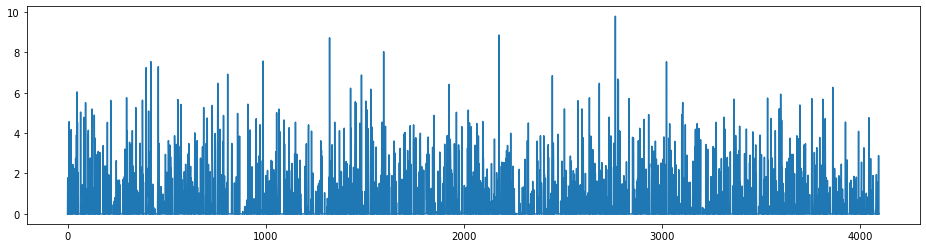

In [9]:
img, x = load_image("./data/images/187870/0.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [10]:
images_path = "./data/images"
image_extensions = ['.jpg']

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
print("keeping %d images to analyze" % len(images))

keeping 9388 images to analyze


In [11]:
# tic = time.process_time()

# features = []
# for i, image_path in enumerate(images):
#     if i % 500 == 0:
#         toc = time.process_time()
#         elap = toc-tic
#         print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
#         tic = time.process_time()
#     img, x = load_image(image_path)
#     feat = feat_extractor.predict(x)[0]
#     features.append(feat)

# print('finished extracting features for %d images' % len(images))

In [12]:
# np.save('features.npy', features)

In [13]:
features = np.load("features.npy")
pca = PCA(n_components=300)
pca.fit(features)


PCA(n_components=300)

In [14]:
pca_features = pca.transform(features)

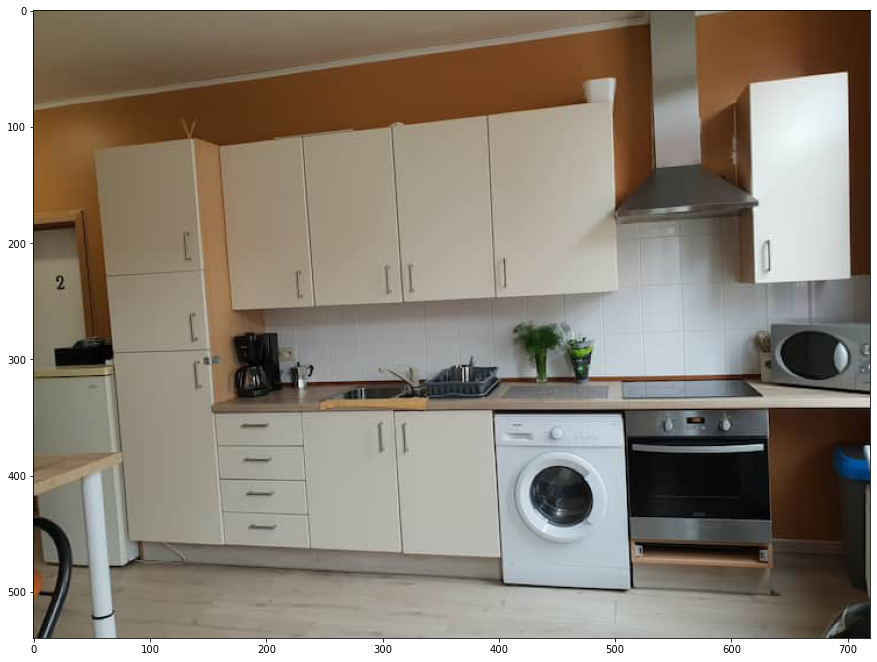

In [15]:
query_image_idx = int(len(images) * random.random())

img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [16]:
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [17]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

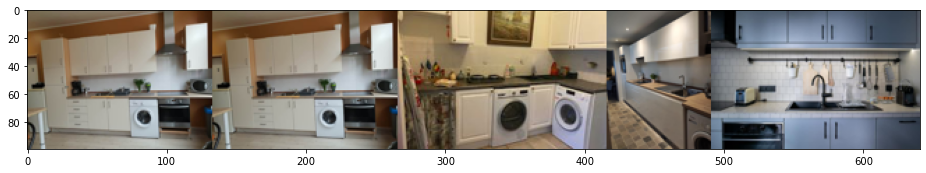

In [18]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [ ]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [ ]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

# **3 - FINDING DUPLICATE LISTINGS BASED ON THE IMAGES**

# **4 - CLUSTERING THE IMAGES**

# **5 - AUTOMATICALLY DETECT ATTRIBUTES OF LISTINGS BASED ON THE IMAGES**

# **6 - DETECTING ANOMALIES BASED ON THE IMAGES**

# **7 - PREDICTING WHICH ROOM A PICTURE IS TAKEN IN**

# **8 - USING EXTERNAL DATA TO BETTER PREDICT THE PRICE**

# **9 - EXTRA 1**

# **10 - EXTRA 2**

# **11 - EXTRA 3**